In [1]:
import math
import matplotlib
from decimal import ROUND_HALF_UP, Decimal
import numpy as np
import pandas as pd
import seaborn as sns
import time
import talib
import copy

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.utils import plot_model, timeseries_dataset_from_array

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

2023-05-31 19:07:39.926295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv("~/study/optimal_investment/stock-market-prediction-project/data/my/train_data_2.csv")
test_data = pd.read_csv("~/study/optimal_investment/stock-market-prediction-project/data/my/test_data_2.csv")
data

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target,SMA,WMA,MOM,ADO,CCI,RSI,LWR,MACD,STCK,STCD
0,2017-02-22,1301,2900.0,2937.0,2895.0,2927.0,54500,0.005806,2820.0,2826.247619,190.0,44660.739153,162.932576,91.881396,-4.716981,40.488034,95.228137,91.507034
1,2017-02-23,1301,2903.0,2939.0,2903.0,2928.0,30100,0.000340,2839.1,2844.142857,191.0,48543.732929,133.727392,91.934413,-5.445545,45.844737,94.051318,93.756914
2,2017-02-24,1301,2923.0,2946.0,2919.0,2945.0,32400,0.008486,2859.1,2862.323810,200.0,55264.618298,117.303307,92.820070,-0.526316,50.875262,94.200059,94.493171
3,2017-02-27,1301,2950.0,2978.0,2931.0,2946.0,51600,0.014810,2875.5,2878.542857,164.0,47051.523899,109.118291,92.871233,-15.841584,54.316554,88.512228,92.254535
4,2017-02-28,1301,2963.0,2985.0,2949.0,2971.0,45400,0.001658,2892.5,2896.047619,170.0,42624.311391,103.815130,94.049137,-7.865169,58.388032,86.191626,89.634638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264526,2021-11-29,9997,678.0,679.0,665.0,668.0,320800,0.026987,712.1,710.714286,-88.0,-246797.427693,-174.473863,12.457561,-96.907216,-31.758368,13.268213,14.689111
2264527,2021-11-30,9997,670.0,689.0,667.0,667.0,296300,-0.001460,704.1,702.914286,-80.0,-339057.020588,-128.834356,12.315605,-97.530864,-33.278316,7.359924,11.558693
2264528,2021-12-01,9997,661.0,688.0,660.0,685.0,339100,0.017544,699.5,698.428571,-46.0,-261201.215810,-86.224621,28.590144,-67.948718,-32.654020,19.426289,13.351475
2264529,2021-12-02,9997,681.0,692.0,680.0,684.0,342900,0.014368,694.5,694.571429,-50.0,-241973.730599,-43.269908,28.266296,-64.705882,-31.872547,36.622056,21.136090


In [3]:
sec_codes = data.SecuritiesCode.unique()
len(sec_codes)

2000

In [4]:
scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
ti = ["SMA", "WMA", "MOM", "ADO", "CCI", "RSI", "LWR", "MACD", "STCK", "STCD"]
features = ["Target"]+ti
# target = target_scaler.fit_transform(data[["Close"]])
ti_scaled = scaler.fit_transform(data[ti])
test_data_scaled = scaler.fit_transform(test_data[ti])
pd.DataFrame(ti_scaled, columns=ti)

,SMA,WMA,MOM,ADO,CCI,RSI,LWR,MACD,STCK,STCD
0,0.999548,0.999549,0.001236,0.387639,0.744399,0.917634,0.709009,0.000367,0.413697,0.324503
1,0.999548,0.999549,0.001236,0.387646,0.700591,0.918172,0.709003,0.000367,0.413648,0.324623
2,0.999548,0.999549,0.001236,0.387658,0.675955,0.927157,0.709046,0.000367,0.413654,0.324662
3,0.999548,0.999549,0.001235,0.387643,0.663677,0.927676,0.708911,0.000367,0.413419,0.324543
4,0.999548,0.999549,0.001235,0.387635,0.655723,0.939627,0.708981,0.000367,0.413323,0.324402
...,...,...,...,...,...,...,...,...,...,...
2264526,0.999539,0.999540,0.001227,0.387098,0.238289,0.111853,0.708195,0.000364,0.410304,0.320391
2264527,0.999539,0.999540,0.001227,0.386927,0.306748,0.110413,0.708190,0.000364,0.410059,0.320223
2264528,0.999539,0.999540,0.001228,0.387071,0.370663,0.275523,0.708451,0.000364,0.410559,0.320319
2264529,0.999539,0.999540,0.001228,0.387107,0.435095,0.272238,0.708480,0.000364,0.411271,0.320736


In [5]:
# interm = pd.concat([data[["Date", "SecuritiesCode", "Close"]], pd.DataFrame(target, columns=["Close"])], axis=1)
scaled_data = pd.concat([data[["Date", "SecuritiesCode", "Target"]], pd.DataFrame(ti_scaled, columns=ti)], axis=1)
test_data_scaled = pd.concat([test_data[["Date", "SecuritiesCode", "Target"]], pd.DataFrame(test_data_scaled, columns=ti)], axis=1)
scaled_data

,Date,SecuritiesCode,Target,SMA,WMA,MOM,ADO,CCI,RSI,LWR,MACD,STCK,STCD
0,2017-02-22,1301,0.005806,0.999548,0.999549,0.001236,0.387639,0.744399,0.917634,0.709009,0.000367,0.413697,0.324503
1,2017-02-23,1301,0.000340,0.999548,0.999549,0.001236,0.387646,0.700591,0.918172,0.709003,0.000367,0.413648,0.324623
2,2017-02-24,1301,0.008486,0.999548,0.999549,0.001236,0.387658,0.675955,0.927157,0.709046,0.000367,0.413654,0.324662
3,2017-02-27,1301,0.014810,0.999548,0.999549,0.001235,0.387643,0.663677,0.927676,0.708911,0.000367,0.413419,0.324543
4,2017-02-28,1301,0.001658,0.999548,0.999549,0.001235,0.387635,0.655723,0.939627,0.708981,0.000367,0.413323,0.324402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264526,2021-11-29,9997,0.026987,0.999539,0.999540,0.001227,0.387098,0.238289,0.111853,0.708195,0.000364,0.410304,0.320391
2264527,2021-11-30,9997,-0.001460,0.999539,0.999540,0.001227,0.386927,0.306748,0.110413,0.708190,0.000364,0.410059,0.320223
2264528,2021-12-01,9997,0.017544,0.999539,0.999540,0.001228,0.387071,0.370663,0.275523,0.708451,0.000364,0.410559,0.320319
2264529,2021-12-02,9997,0.014368,0.999539,0.999540,0.001228,0.387107,0.435095,0.272238,0.708480,0.000364,0.411271,0.320736


In [6]:
# for code in sec_codes:      !!!!!!!
stock_data = scaled_data[scaled_data.SecuritiesCode==1301]
stock_data_test = test_data_scaled[test_data_scaled.SecuritiesCode==1301]

# *********************************************************************************
# target_scaler = MinMaxScaler()
# target = stock_data[["Target"]]
# target_test = stock_data_test[["Target"]]
# print(pd.concat([target, target_test]).shape)
# scaled_target = target_scaler.fit_transform(pd.concat([target, target_test]).values)
# scaled_target_size = len(stock_data.Target)
# scaled_target_copy = scaled_target.copy()
# scaled_target = scaled_target_copy[:scaled_target_size]
# scaled_target_test = scaled_target_copy[scaled_target_size:]
# *********************************************************************************

# data_size = stock_data.shape[0]
# train_size = math.ceil(data_size*0.6)
# val_size = math.ceil(data_size*0.2)

# train_data = stock_data[:train_size]
# val_data = stock_data[train_size:train_size+val_size]
# test_data = stock_data[train_size+val_size:]

# *********************************************************************************
# scaled_train_data = stock_data.copy()
# scaled_train_data["Target"] = scaled_target
# scaled_test_data = stock_data_test.copy()
# scaled_test_data["Target"] = scaled_target_test
# *********************************************************************************

print(f"train_data.shape: {stock_data.shape}, test_data.shape: {stock_data_test.shape}")
# print(f"scaled_train_data.shape: {scaled_train_data.shape}, scaled_test_data: {scaled_test_data.shape}")

stock_data

train_data.shape: (1168, 13), test_data.shape: (1168, 13)


,Date,SecuritiesCode,Target,SMA,WMA,MOM,ADO,CCI,RSI,LWR,MACD,STCK,STCD
0,2017-02-22,1301,0.005806,0.999548,0.999549,0.001236,0.387639,0.744399,0.917634,0.709009,0.000367,0.413697,0.324503
1,2017-02-23,1301,0.000340,0.999548,0.999549,0.001236,0.387646,0.700591,0.918172,0.709003,0.000367,0.413648,0.324623
2,2017-02-24,1301,0.008486,0.999548,0.999549,0.001236,0.387658,0.675955,0.927157,0.709046,0.000367,0.413654,0.324662
3,2017-02-27,1301,0.014810,0.999548,0.999549,0.001235,0.387643,0.663677,0.927676,0.708911,0.000367,0.413419,0.324543
4,2017-02-28,1301,0.001658,0.999548,0.999549,0.001235,0.387635,0.655723,0.939627,0.708981,0.000367,0.413323,0.324402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,2021-11-29,1301,0.003793,0.999549,0.999550,0.001225,0.387530,0.273772,0.326501,0.708168,0.000364,0.409939,0.319890
1164,2021-11-30,1301,0.007558,0.999549,0.999550,0.001224,0.387516,0.269394,0.270329,0.708168,0.000364,0.409853,0.319806
1165,2021-12-01,1301,0.016706,0.999549,0.999550,0.001223,0.387509,0.296105,0.298038,0.708210,0.000364,0.409871,0.319777
1166,2021-12-02,1301,-0.003689,0.999549,0.999550,0.001226,0.387502,0.390206,0.352664,0.708330,0.000364,0.410285,0.319926


In [7]:
window_size = 30

In [8]:
def partition_dataset(sequence_length, data):
    data = np.array(data)
    x, y = [], []
    data_len = data.shape[0]
    print(data_len)
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i, 1:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, 0]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [9]:
train_df = stock_data[["Target"]+ti]
test_df = stock_data_test[["Target"]+ti]
# print(test_df.shape)
x_train, y_train = partition_dataset(window_size, train_df)
print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
x_test, y_test = partition_dataset(window_size, test_df)
print(f"x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}")

1168
x_train.shape: (1138, 30, 10), y_train.shape: (1138,)
1168
x_test.shape: (1138, 30, 10), y_test.shape: (1138,)


In [10]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(7, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

300 30 10


2023-05-31 19:08:00.894954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Training the model
epochs = 6
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop]
                   )

Epoch 1/6
72/72 [==============================] - 10s 100ms/step - loss: 0.0024 - val_loss: 1.7153e-04
Epoch 2/6
72/72 [==============================] - 7s 93ms/step - loss: 1.7003e-04 - val_loss: 1.6935e-04
Epoch 3/6
72/72 [==============================] - 6s 78ms/step - loss: 1.6954e-04 - val_loss: 1.6941e-04
Epoch 4/6
72/72 [==============================] - 6s 85ms/step - loss: 1.6951e-04 - val_loss: 1.6938e-04
Epoch 5/6
72/72 [==============================] - 6s 79ms/step - loss: 1.6964e-04 - val_loss: 1.6936e-04
Epoch 6/6
72/72 [==============================] - 6s 79ms/step - loss: 1.6988e-04 - val_loss: 1.6964e-04


In [12]:
y_pred = model.predict(x_test)
y_pred.shape# y_pred = target_scaler.inverse_transform(y_pred_scaled)
# y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1,1))
print(f"y_pred: {y_pred.shape}, y_test.shape: {y_test.shape}")
# # y_test = 
y_test[0], y_pred[0]
# y_pred

36/36 [==============================] - 2s 37ms/step
y_pred: (1138, 1), y_test.shape: (1138,)


(-0.0061141304347825, array([-0.00041833], dtype=float32))

In [13]:
MAE = mean_absolute_error(y_test, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
print(f'Root Mean Squared Error (RMSE): {np.round(RMSE, 2)} %')

Median Absolute Error (MAE): 0.01
Root Mean Squared Error (RMSE): 0.01 %


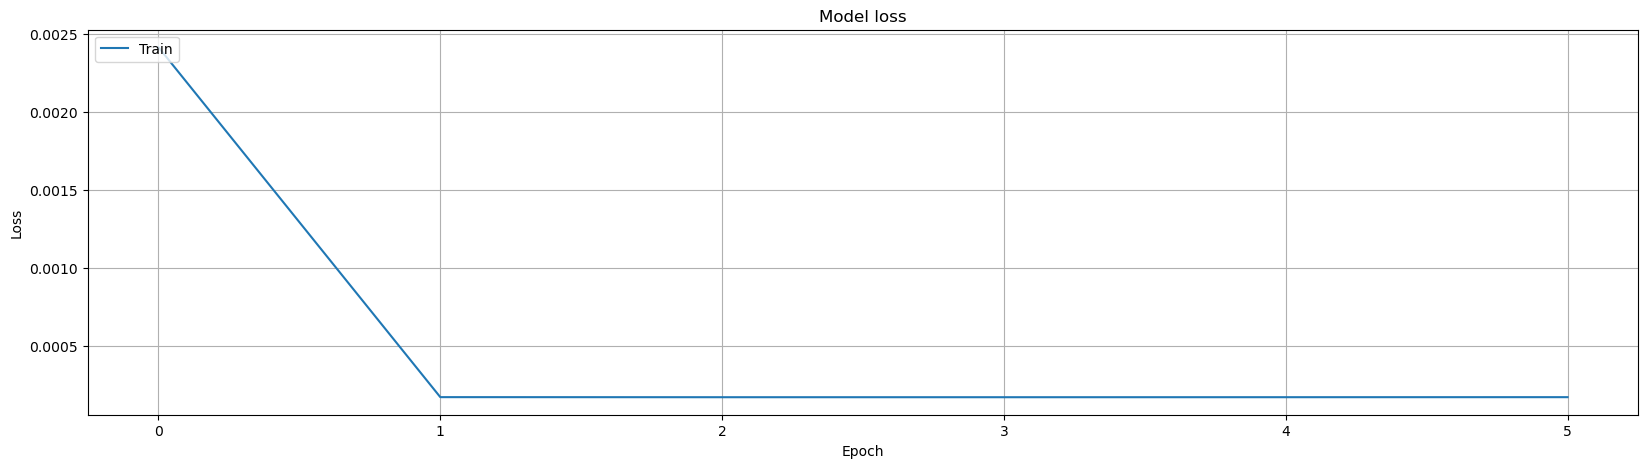

In [14]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

(1168, 11)


<Axes: title={'center': 'predict vs test'}, xlabel='Date', ylabel='1301'>

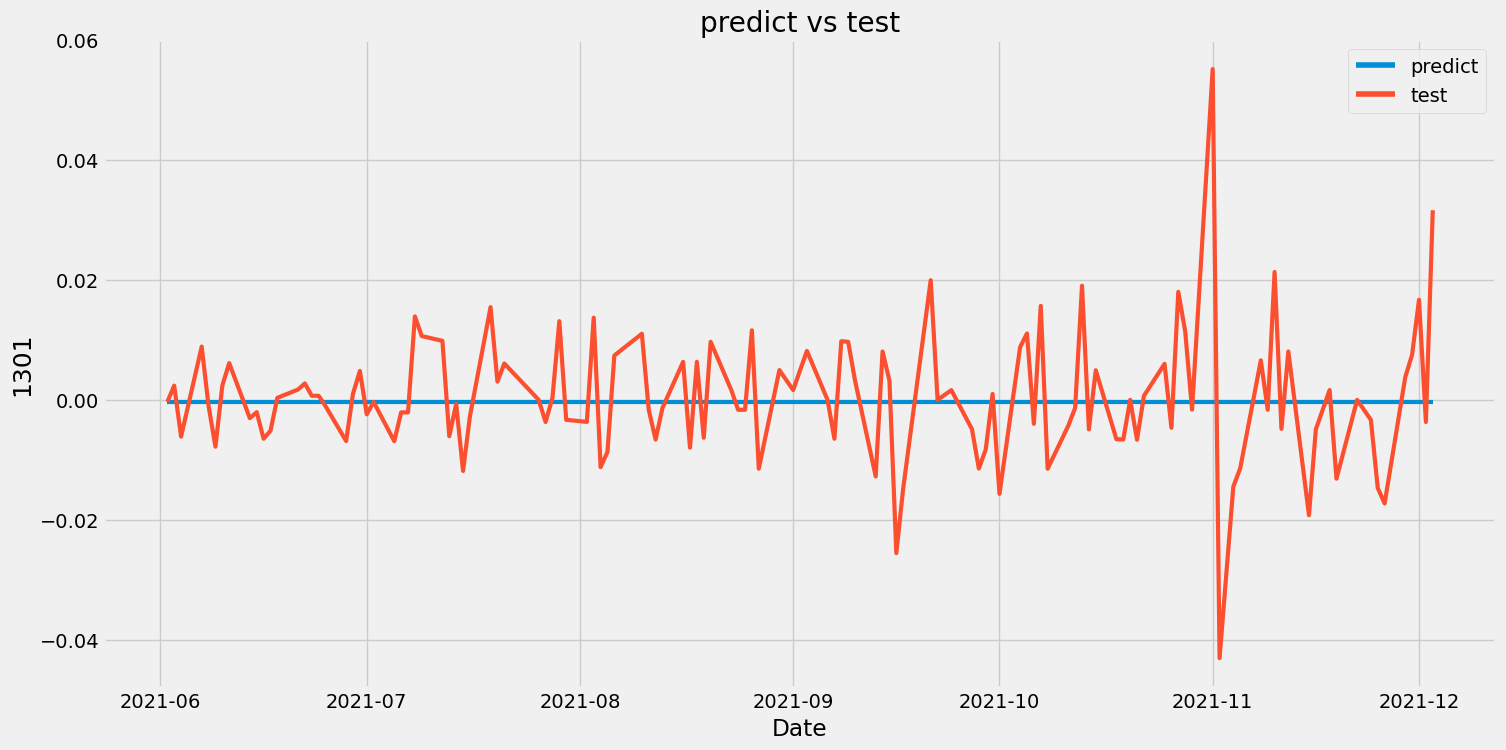

In [15]:
# The date from which on the date is displayed
display_start_date = "2021-6-01"

col = "Target"
# Add the difference between the valid and predicted prices
print(test_df.shape)
train_pl = pd.DataFrame(train_df[col]).rename(columns={col: 'train'})
train_pl.index = pd.to_datetime(stock_data.Date, format='%Y-%m-%d')
test_pl = pd.DataFrame(test_df[col][window_size:]).rename(columns={col: 'test'})
test_pl.index = pd.to_datetime(stock_data_test[window_size:].Date, format='%Y-%m-%d')

test_pl.insert(1, "predict", y_pred, True)
test_pl.insert(1, "residuals", test_pl["predict"] - test_pl["test"], True)
df_union = pd.concat([train_pl, test_pl])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
plt.style.use("fivethirtyeight")
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("predict vs test")
plt.ylabel(1301, fontsize=18)
# sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['predict', 'test']], linewidth=3.0, dashes=False, ax=ax1)


### Average RMSE

In [16]:
def train_models(data, test_data, size):
    RMSE_list = []
    y_pred_list = []
    y_test_list = []
    for code in sec_codes[:size]:
        stock_data = data[data.SecuritiesCode==code]
        stock_data_test = test_data[test_data.SecuritiesCode==code]
        print(f"train_data.shape: {stock_data.shape}, test_data.shape: {stock_data_test.shape}")

        train_df = stock_data[["Target"]+features]
        test_df = stock_data_test[["Target"]+features]
        # print(test_df.shape)
        x_train, y_train = partition_dataset(window_size, train_df)
        print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
        x_test, y_test = partition_dataset(window_size, test_df)
        print(f"x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}")

        model = Sequential()
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])
        model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(LSTM(n_neurons, return_sequences=False))
        model.add(Dense(7, activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

        # Training the model
        epochs = 6
        batch_size = 16
        early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
        history = model.fit(x_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[early_stop]
                           )
        y_pred = model.predict(x_test)
        RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
        RMSE_list.append(RMSE)
        y_pred_list.append(y_pred)
        y_test_list.append(y_test)
    return y_test_list, y_pred_list, RMSE_list

In [18]:
y_test_list, y_pred_list, RMSE_list = train_models(scaled_data, test_data_scaled, 10)

train_data.shape: (1168, 13), test_data.shape: (1168, 13)
1168
x_train.shape: (1138, 30, 11), y_train.shape: (1138,)
1168
x_test.shape: (1138, 30, 11), y_test.shape: (1138,)
330 30 11
Epoch 1/6
72/72 [==============================] - 12s 116ms/step - loss: 3.9207e-04 - accuracy: 0.0387 - val_loss: 1.6957e-04 - val_accuracy: 0.0387
Epoch 2/6
72/72 [==============================] - 7s 101ms/step - loss: 1.7002e-04 - accuracy: 0.0387 - val_loss: 1.6953e-04 - val_accuracy: 0.0387
Epoch 3/6
72/72 [==============================] - 8s 105ms/step - loss: 1.6990e-04 - accuracy: 0.0387 - val_loss: 1.6938e-04 - val_accuracy: 0.0387
Epoch 4/6
72/72 [==============================] - 8s 105ms/step - loss: 1.6984e-04 - accuracy: 0.0387 - val_loss: 1.6936e-04 - val_accuracy: 0.0387
Epoch 5/6
72/72 [==============================] - 8s 108ms/step - loss: 1.7009e-04 - accuracy: 0.0387 - val_loss: 1.6945e-04 - val_accuracy: 0.0387
Epoch 6/6
36/36 [==============================] - 3s 55ms/step
train_

AttributeError: 'list' object has no attribute 'mean'

In [19]:
RMSE = np.mean(RMSE_list)
print(f'Root Mean Squared Error (RMSE): {np.round(RMSE, 2)} %')

Root Mean Squared Error (RMSE): 0.02 %
